In [17]:
from zipfile import ZipFile
import cv2
import random
from PIL import Image
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [18]:

# Double convolution block
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

# Encoder block with double conv and downsampling
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.double_conv = double_conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        x_pooled = self.pool(x)
        return x, x_pooled

# Decoder block with upsampling and double conv
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = double_conv(out_channels + skip_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        if x.size() != skip_connection.size():
            x = F.pad(x, [0, skip_connection.size(3) - x.size(3), 0, skip_connection.size(2) - x.size(2)])
        x = torch.cat((x, skip_connection), dim=1)
        x = self.double_conv(x)
        return x

# Main model
class LowLightEnhancementModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(LowLightEnhancementModel, self).__init__()
        self.initial_conv = double_conv(in_channels, 16)
        
        self.encoder1 = EncoderBlock(16, 32)
        self.encoder2 = EncoderBlock(32, 64)
        self.encoder3 = EncoderBlock(64, 128)
        self.encoder4 = EncoderBlock(128, 256)
        
        self.bottleneck = double_conv(256, 512)
        
        self.decoder4 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 32, 32)
        
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder path
        x0 = self.initial_conv(x)
        x1, x1_pooled = self.encoder1(x0)
        x2, x2_pooled = self.encoder2(x1_pooled)
        x3, x3_pooled = self.encoder3(x2_pooled)
        x4, x4_pooled = self.encoder4(x3_pooled)
        
        # Bottleneck
        x_bottleneck = self.bottleneck(x4_pooled)
        
        # Decoder path with skip connections
        x = self.decoder4(x_bottleneck, x4)
        x = self.decoder3(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder1(x, x1)
        
        # Final convolution
        x = self.final_conv(x)
        return x

In [20]:
from torch.utils.data import Dataset
import os


class LowLightDataset(Dataset):
    def __init__(self, low_img_dir, high_img_dir, transform=None):
        self.low_img_dir = low_img_dir
        self.high_img_dir = high_img_dir
        self.low_images = os.listdir(low_img_dir)
        self.high_images = os.listdir(high_img_dir)
        self.transform = transform

        # Ensure that we use the minimum length of both lists
        self.length = min(len(self.low_images), len(self.high_images))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_img_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_img_dir, self.high_images[idx])

        low_image = Image.open(low_img_path).convert("RGB")
        high_image = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

transform = transforms.Compose([
    transforms.ToTensor(),
])



  
# Dataset paths
train_low_dir = '/kaggle/input/dataset00/augmented_Train/augmented/low'
train_high_dir = '/kaggle/input/dataset00/augmented_Train/augmented/high'
val_low_dir = '/kaggle/input/dataset00/augmented_Train/val/low'
val_high_dir = '/kaggle/input/dataset00/augmented_Train/val/high'



train_dataset = LowLightDataset(train_low_dir, train_high_dir, transform=transform)
val_dataset = LowLightDataset(val_low_dir, val_high_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)'''

In [56]:

# SSIM Loss implementation
import torch
import torch.nn.functional as F
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2
    
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
        
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        
        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel
            
        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)
    

l1_loss = nn.L1Loss()

def fft_loss(pred, target):
    pred_fft = torch.fft.fft2(pred)
    target_fft = torch.fft.fft2(target)
    return nn.functional.l1_loss(pred_fft, target_fft)

class CombinedLoss(nn.Module):
    def __init__(self, ssim_weight=0.5, l1_weight=0.1, fft_weight=0.4):
        super(CombinedLoss, self).__init__()
        self.ssim_loss = SSIM()
        self.l1_loss = nn.L1Loss()
        self.fft_loss = fft_loss
        self.ssim_weight = ssim_weight
        self.l1_weight = l1_weight
        self.fft_weight = fft_weight

    def forward(self, pred, target):
        loss_ssim = 1 - self.ssim_loss(pred, target)
        loss_l1 = self.l1_loss(pred, target)
        loss_fft = self.fft_loss(pred, target)
        combined_loss = (
            self.ssim_weight * loss_ssim +
            self.l1_weight * loss_l1 +
            self.fft_weight * loss_fft
        )
        return combined_loss

In [58]:
from torch.optim.lr_scheduler import CosineAnnealingLR

model = LowLightEnhancementModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001)
criterion =CombinedLoss(ssim_weight=0.5, l1_weight=0.1, fft_weight=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LowLightEnhancementModel(
  (initial_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder1): EncoderBlock(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en

In [59]:
model = LowLightEnhancementModel(in_channels=3, out_channels=3)
model_path = "/kaggle/input/newaugment1/new-augmentation(1).pth"
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)
print("Model loaded successfully")

Model loaded successfully


In [64]:
def calculate_psnr(output, target):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return float('inf') 
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    psnr_total = 0.0

    for low_images, high_images in train_loader:
        low_images, high_images = low_images.to(device), high_images.to(device)
        optimizer.zero_grad()
        outputs = model(low_images)
        loss = criterion(outputs, high_images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate PSNR for the current batch
        psnr = calculate_psnr(outputs, high_images)
        psnr_total += psnr
        
        scheduler.step()

    # Average the loss and PSNR over all batches
    avg_train_loss = train_loss / len(train_loader)
    avg_psnr = psnr_total / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train PSNR: {avg_psnr:.2f} dB")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_psnr_total = 0.0
    with torch.no_grad():
        for low_images, high_images in val_loader:
            low_images, high_images = low_images.to(device), high_images.to(device)
            outputs = model(low_images)
            loss = criterion(outputs, high_images)
            val_loss += loss.item()

            # Calculate PSNR for the current batch
            psnr = calculate_psnr(outputs, high_images)
            val_psnr_total += psnr

    # Average the loss and PSNR over all batches
    avg_val_loss = val_loss / len(val_loader)
    avg_val_psnr = val_psnr_total / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation PSNR: {avg_val_psnr:.2f} dB")

Epoch 1/10, Train Loss: 4.7444, Train PSNR: 18.47 dB
Epoch 1/10, Validation Loss: 5.7108, Validation PSNR: 17.10 dB
Epoch 2/10, Train Loss: 4.7333, Train PSNR: 18.55 dB
Epoch 2/10, Validation Loss: 5.2772, Validation PSNR: 17.49 dB
Epoch 3/10, Train Loss: 4.7368, Train PSNR: 18.36 dB
Epoch 3/10, Validation Loss: 5.3212, Validation PSNR: 17.43 dB
Epoch 4/10, Train Loss: 4.7263, Train PSNR: 18.37 dB
Epoch 4/10, Validation Loss: 5.5245, Validation PSNR: 17.43 dB
Epoch 5/10, Train Loss: 4.7308, Train PSNR: 18.56 dB
Epoch 5/10, Validation Loss: 5.7236, Validation PSNR: 17.23 dB
Epoch 6/10, Train Loss: 4.7342, Train PSNR: 18.54 dB
Epoch 6/10, Validation Loss: 5.3099, Validation PSNR: 17.44 dB
Epoch 7/10, Train Loss: 4.7292, Train PSNR: 18.41 dB
Epoch 7/10, Validation Loss: 5.6344, Validation PSNR: 17.33 dB
Epoch 8/10, Train Loss: 4.7311, Train PSNR: 18.53 dB
Epoch 8/10, Validation Loss: 5.5767, Validation PSNR: 17.49 dB
Epoch 9/10, Train Loss: 4.7356, Train PSNR: 18.47 dB
Epoch 9/10, Validat

In [68]:
model_path = "/kaggle/working/-augmentation.pth"
torch.save(model.state_dict(), model_path)
print("Model state dictionary saved as .pth file")

Model state dictionary saved as .pth file


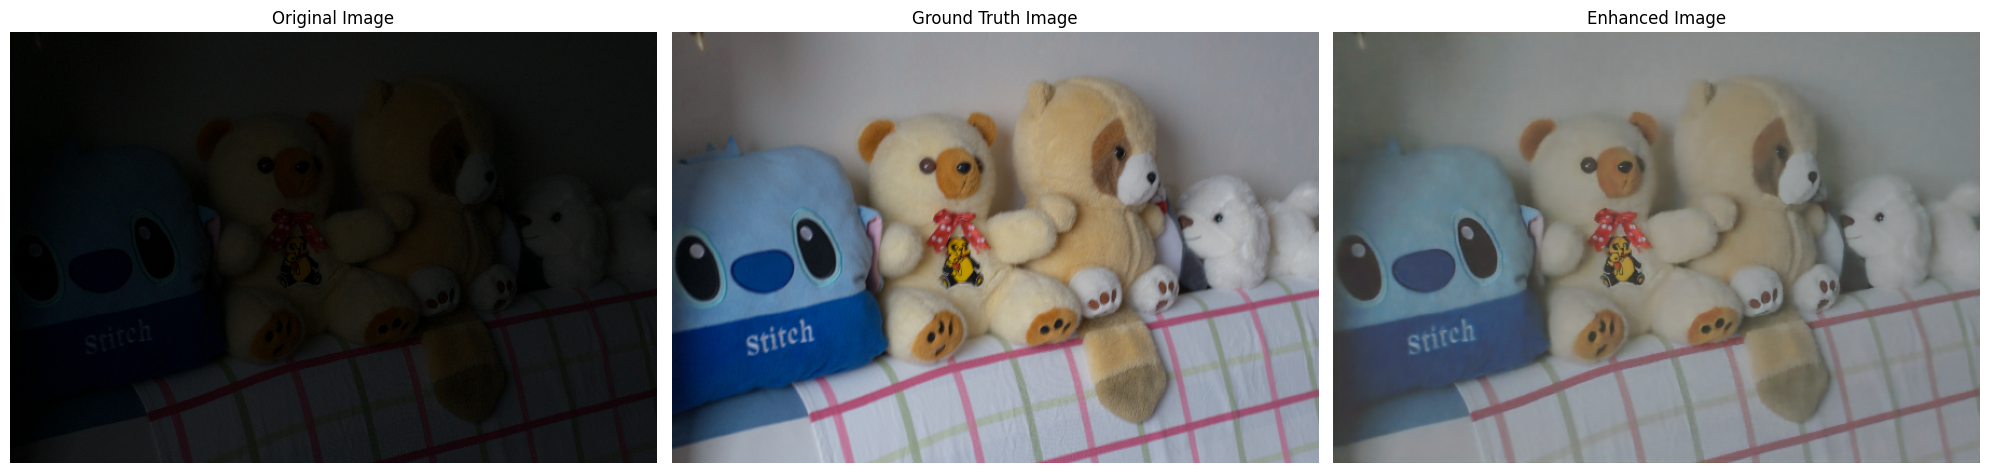

In [65]:
model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 600)),
    transforms.ToTensor()
])

input_image_path = '/kaggle/input/imagedenoise/Train/low/10.png'
ground_truth_path = '/kaggle/input/imagedenoise/Train/high/10.png'

input_image = Image.open(input_image_path).convert('RGB')
ground_truth_image = Image.open(ground_truth_path).convert('RGB')

# Display the original input image, ground truth image, and enhanced image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
ax1.imshow(input_image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(ground_truth_image)
ax2.set_title('Ground Truth Image')
ax2.axis('off')

input_tensor = transform(input_image).unsqueeze(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    enhanced_tensor = model(input_tensor)
    enhanced_tensor = enhanced_tensor.cpu()

enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())
ax3.imshow(enhanced_image)
ax3.set_title('Enhanced Image')
ax3.axis('off')

plt.tight_layout()
plt.show()

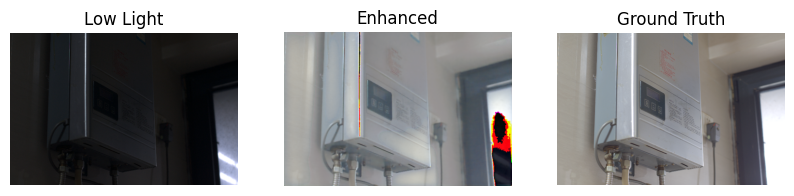

PSNR: 22.94 dB


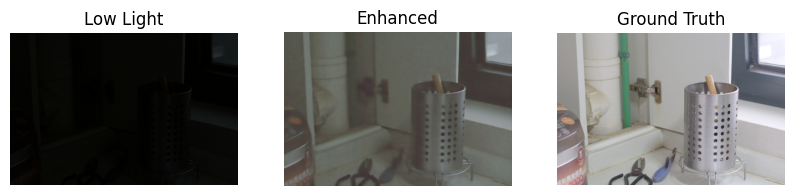

PSNR: 11.06 dB


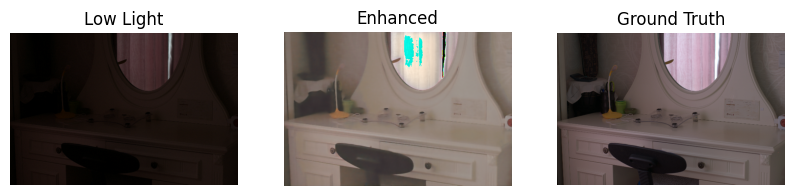

PSNR: 16.33 dB


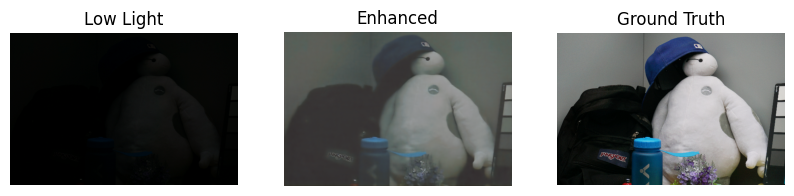

PSNR: 14.90 dB


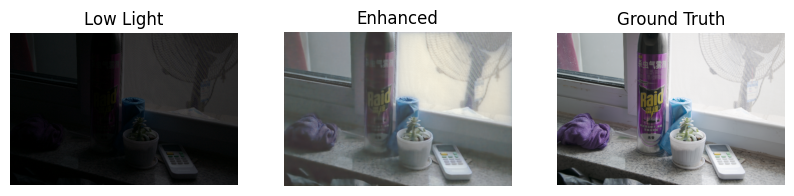

PSNR: 18.65 dB


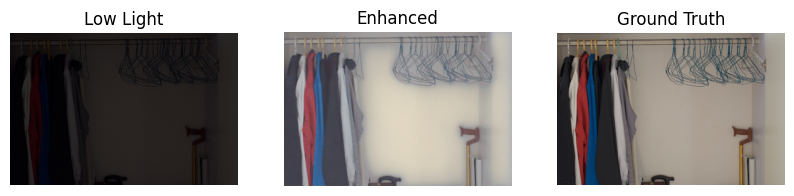

PSNR: 17.29 dB


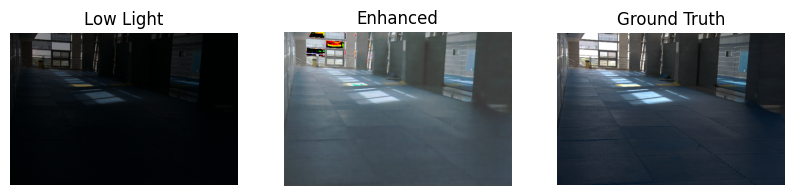

PSNR: 16.11 dB


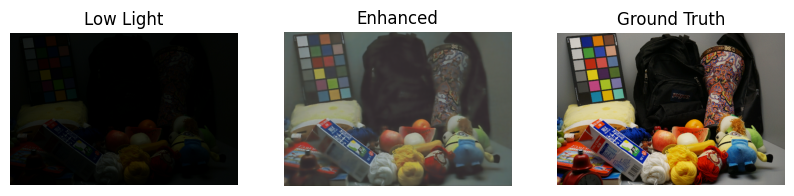

PSNR: 16.90 dB


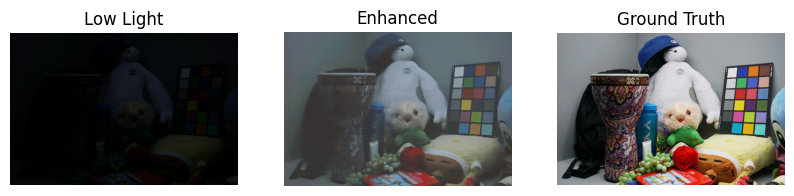

PSNR: 14.56 dB


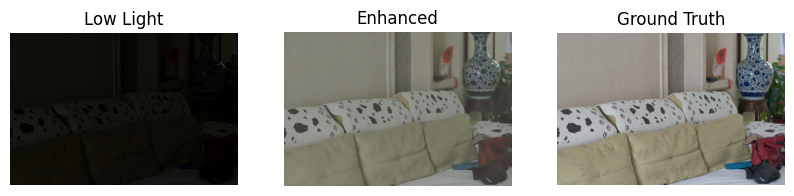

PSNR: 20.87 dB


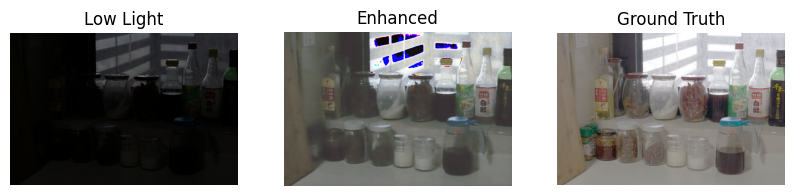

PSNR: 19.92 dB


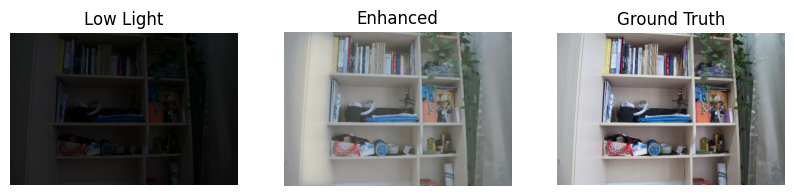

PSNR: 20.92 dB


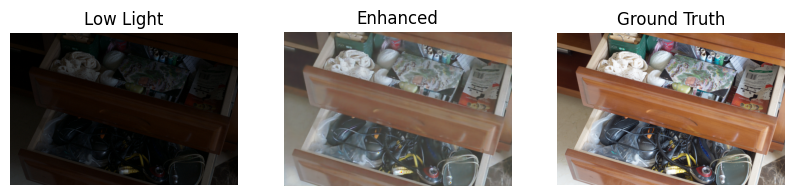

PSNR: 20.68 dB


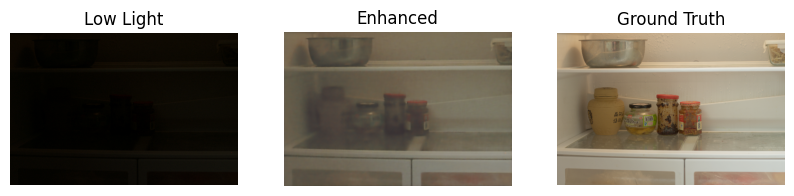

PSNR: 13.90 dB


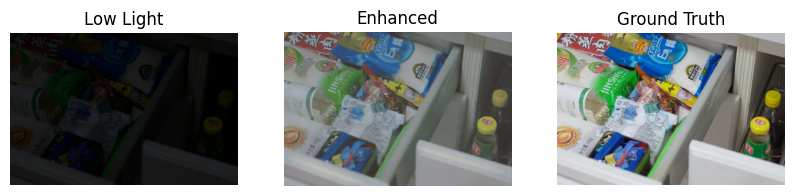

PSNR: 17.14 dB


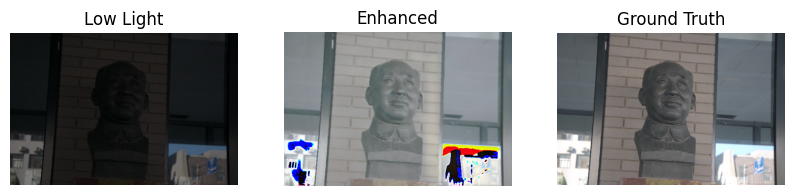

PSNR: 16.60 dB


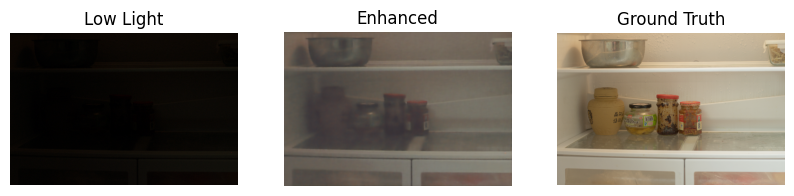

PSNR: 12.44 dB


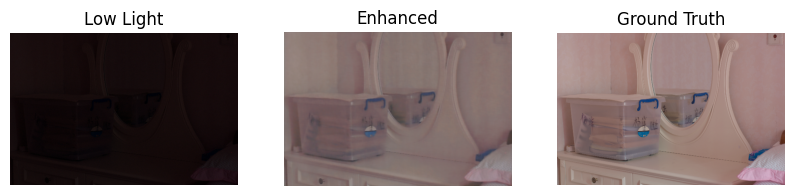

PSNR: 21.36 dB


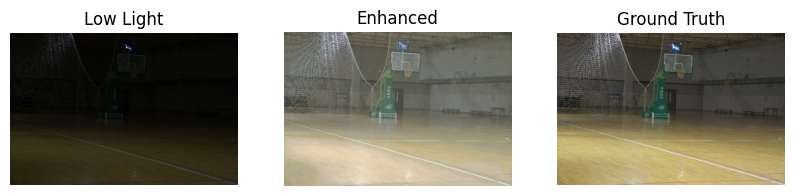

PSNR: 16.46 dB


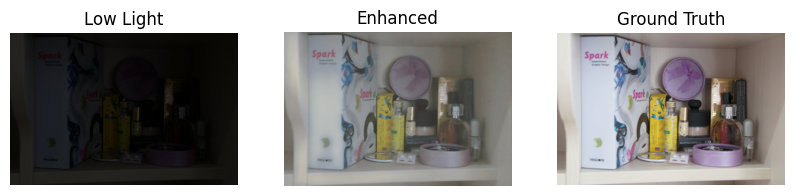

PSNR: 17.96 dB


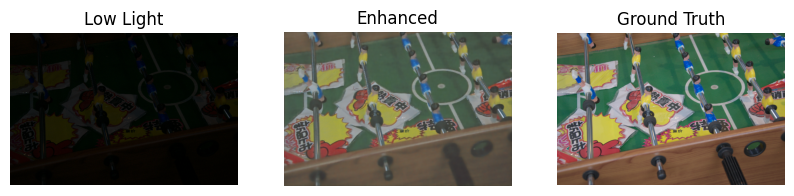

PSNR: 22.22 dB


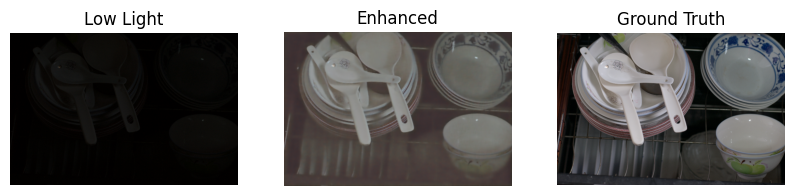

PSNR: 19.27 dB


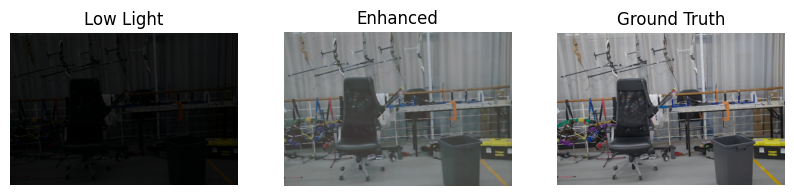

PSNR: 23.00 dB


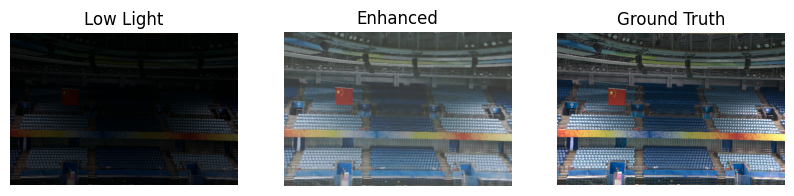

PSNR: 19.17 dB


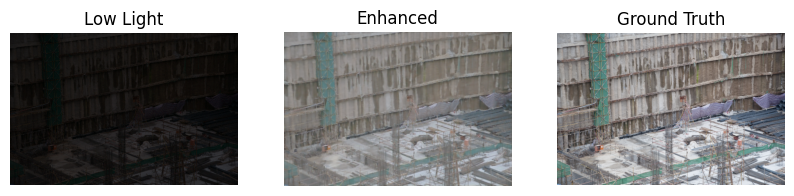

PSNR: 21.26 dB
Average PSNR: 18.08 dB


In [67]:

from torchvision.transforms.functional import pil_to_tensor, to_pil_image

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr


model.eval()
transform = transforms.Compose([
    transforms.Resize((400,592)),
    transforms.ToTensor() 
])
model.eval()

low_dir = '/kaggle/input/imagedenoise/Train/low'
high_dir = '/kaggle/input/imagedenoise/Train/high'

low_images = os.listdir(low_dir)

random_images = random.sample(low_images,25)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

psnr_values = []

for image_name in random_images:
    input_image_path = os.path.join(low_dir, image_name)
    high_image_path = os.path.join(high_dir, image_name)
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = model(input_tensor).cpu()

    enhanced_image = transforms.ToPILImage()(enhanced_tensor.squeeze())

    original_image = cv2.imread(high_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))  
    axs[0].imshow(input_image)
    axs[0].set_title('Low Light')
    axs[0].axis('off')
    
    axs[1].imshow(enhanced_image)
    axs[1].set_title('Enhanced')
    axs[1].axis('off')
    
    axs[2].imshow(original_image_rgb)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    
    plt.show()
    
    original_tensor = transform(Image.fromarray(original_image_rgb)).unsqueeze(0)
    psnr_value = psnr(original_tensor, enhanced_tensor)
    psnr_values.append(psnr_value)
    print(f'PSNR: {psnr_value:.2f} dB')
average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')

In [ ]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import cv2
from torchmetrics.functional import peak_signal_noise_ratio as psnr

model.eval()
transform = transforms.Compose([
    transforms.Resize((400, 592)),
    transforms.ToTensor() 
])
low_dir = './test/low'
high_dir = './test/predicted'

low_images = os.listdir(low_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

psnr_values = []

for image_name in low_images:
    input_image_path = os.path.join(low_dir, image_name)
    high_image_path = os.path.join(high_dir, image_name)
    
    input_image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        enhanced_tensor = model(input_tensor).cpu()

    original_image = cv2.imread(high_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    original_tensor = transform(Image.fromarray(original_image_rgb)).unsqueeze(0)
    
    psnr_value = psnr(original_tensor, enhanced_tensor)
    psnr_values.append(psnr_value.item())

average_psnr = sum(psnr_values) / len(psnr_values)
print(f'Average PSNR: {average_psnr:.2f} dB')